In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
import scikitplot as skplt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%%time
# Load data #
data=pd.read_csv("datafiles/common_input/merged.csv")

#  Print columns of dataset with missing values #
list = data.columns[data.isna().any()].tolist()
print(list)

# Fill NA values with mean of the corresponding column #
for i in list:
    print(i)
    print(data.isna().sum())                      
    data[i].fillna(data[i].mean(), inplace=True)  

[]
CPU times: user 2min 42s, sys: 2.8 s, total: 2min 45s
Wall time: 2min 45s


In [3]:
# Set feature and target columns #
features = data.drop(['step','labels'], axis=1)
target = data['labels']
#print(features.head(n=5))
#print(target.head(n=5))

# Train test split and scale data #
X1,X2,y1,y2 =train_test_split(features, target, stratify=target, test_size= 0.30, random_state=793) # random_state of data shuffling is tuned in PHASE I feature Pre-screening; fixed in PHASE II Classification #
scaler = StandardScaler()
x1 = pd.DataFrame(scaler.fit_transform(X1))                
x2 = pd.DataFrame(scaler.transform(X2))
#print(x1.shape, x2.shape, y1.shape, y2.shape)
#print(x1.head(n=5),y1.head(n=5))
#print(x2.head(n=5),y2.head(n=5))

# To perform cross validation on train set #
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  

In [4]:
# BASE MODEL evaluation #
RF = RandomForestClassifier
base_model = RF(n_estimators=100, random_state=42) # random_state of model fixed in PHASE I feature Pre-screening; tuned in PHASE II Classification #

accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []
specificity_scores = []

# Model evaluation for cross validation on TRAINING DATASET #

for train_index, test_index in cv.split(x1,y1):
    #print(len(train_index))
    #print(len(test_index))
    X_train, X_test = x1.iloc[train_index], x1.iloc[test_index]
    y_train, y_test = y1.iloc[train_index], y1.iloc[test_index]
    base_model.fit(X_train, y_train)
    y_pred = base_model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    
    accuracy_scores.append(acc)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    specificity_scores.append(specificity)
    
avg_acc=np.mean(accuracy_scores)
avg_f1=np.mean(f1_scores)
avg_precision=np.mean(precision_scores)
avg_recall=np.mean(recall_scores)
avg_specificity=np.mean(specificity_scores)

scoredata = pd.DataFrame()
valscoredict = pd.DataFrame({'Data':'Validation','score_accuracy':avg_acc,'score_f1':avg_f1,'score_precision':avg_precision,'score_recall':avg_recall, 'score_specificity': avg_specificity}, index=[0])
scoredata=pd.concat([scoredata, valscoredict], axis=0)
print(scoredata)

# Model evaluation on TEST DATASET #

base_model.fit(x1, y1)
y2_base_predict = pd.Series(base_model.predict(x2))

base_test_accuracy = accuracy_score(y2, y2_base_predict)
base_test_f1 = f1_score(y2, y2_base_predict)
base_test_precision = precision_score(y2, y2_base_predict)
base_test_recall = recall_score(y2, y2_base_predict)
base_test_specificity = cm[0,0]/(cm[0,0]+cm[0,1])

testscoredict = pd.DataFrame({'Data':'Test','score_accuracy':base_test_accuracy,'score_f1':base_test_f1,'score_precision':base_test_precision,'score_recall':base_test_recall, 'score_specificity': base_test_specificity},index=[0])
scoredata=pd.concat([scoredata, testscoredict], axis=0)
print(scoredata)

         Data  score_accuracy  score_f1  score_precision  score_recall  \
0  Validation             1.0       1.0              1.0           1.0   

   score_specificity  
0                1.0  
         Data  score_accuracy  score_f1  score_precision  score_recall  \
0  Validation             1.0       1.0              1.0           1.0   
0        Test             1.0       1.0              1.0           1.0   

   score_specificity  
0                1.0  
0                1.0  


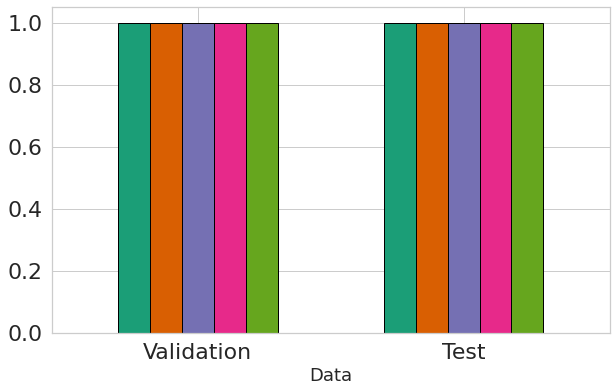

In [5]:
## PLOTS for BASE MODEL ##
sns.set(font_scale = 1.5)
sns.set_style("whitegrid")

# Plot classification scores #
c = plt.get_cmap('Dark2')
scoredata.plot.bar(x="Data", rot=0, width=0.6, figsize=(10,6), fontsize=22, legend=False, edgecolor="black", linewidth=1, color = c.colors)
#plt.savefig("barplot.png", dpi=300)
plt.show()

269-300    0.038738
138-300    0.023529
216-300    0.017178
209-300    0.014719
170-208    0.012923
             ...   
78-133     0.000000
78-134     0.000000
78-135     0.000000
78-136     0.000000
302-303    0.000000
Name: Importance, Length: 38226, dtype: float64
         Importance  Cumulative
269-300    0.038738    0.038738
138-300    0.023529    0.062268
216-300    0.017178    0.079446
209-300    0.014719    0.094165
170-208    0.012923    0.107088
...             ...         ...
76-129     0.000065    0.989735
56-183     0.000065    0.989800
89-292     0.000065    0.989865
150-255    0.000065    0.989930
191-244    0.000064    0.989994

[485 rows x 2 columns]


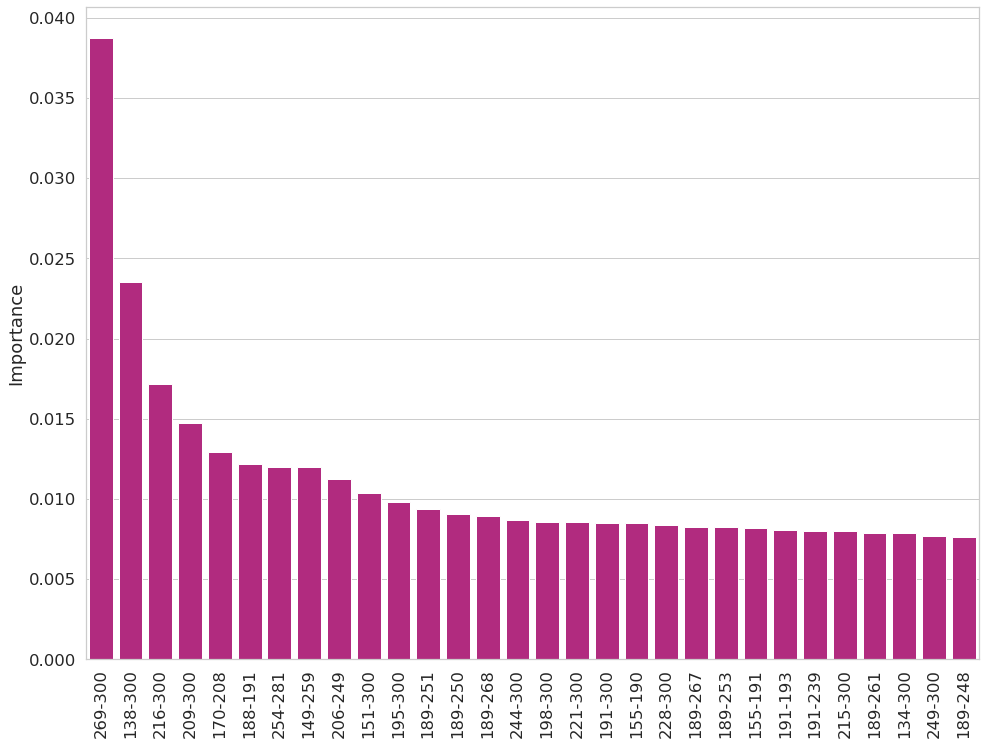

In [6]:
# Extract feature importance #
feature_imp = pd.Series(base_model.feature_importances_, index=features.columns, name='Importance').sort_values(ascending=False)
imp = feature_imp
print(imp)

cumsum = pd.Series(imp.cumsum(),name='Cumulative')
mergedscore = pd.DataFrame(pd.concat([feature_imp, cumsum], axis=1))
#mergedscore.to_csv("RF1-PhaseI-seed793.csv", sep=",")

# Filter features which contribute to 99% total importance of classification #
filt = (mergedscore['Cumulative'] < 0.99) 
df1 = mergedscore[filt]
print(df1)

# Feature Importance Plot #
plt.figure(figsize=(16,12))
topf=df1.iloc[:30]
sns.barplot(x=topf.index, y=topf['Importance'], data=topf, color="mediumvioletred")
plt.xticks(rotation='vertical')
#plt.savefig("basemodel-featureimp.png", dpi=300)
plt.show()

In [7]:
# Phase I Pre-screening (first feature selection step that generates a new reduced dataset --> 'screened-seed793.csv') #
# The same script was run in multiple iterations using different random_state values (mentioned in manuscript) to:
# 1.) create independent pre-screened datasets for multiple Phase II RF-based classifications #
# 2.) create a composite pre-screened dataset for training all MLP architectures # 
list = df1.index
df2 = features[list]
screened= pd.concat([df2, data['labels']], axis=1)
print(screened)
#screened.to_csv("screened-seed793.csv", sep=",") 

      269-300  138-300  216-300  209-300  170-208  188-191  254-281  149-259  \
0     36.3933  22.0435  24.4857  33.0677  21.9851  6.61611  21.1252  28.8488   
1     36.1771  22.0200  24.1525  33.1894  22.8674  6.63208  21.3824  29.4294   
2     36.1183  21.0856  23.5215  33.0162  22.1880  7.37621  20.2510  29.5144   
3     35.4058  21.6323  23.5189  32.5268  22.4293  7.07240  21.1076  29.3064   
4     36.3798  21.8152  24.9315  32.9518  21.9431  7.70230  20.5298  29.5283   
...       ...      ...      ...      ...      ...      ...      ...      ...   
7495  37.2091  23.3737  25.5418  34.1065  18.2432  3.79640  21.2084  31.1182   
7496  37.7496  23.4166  26.0062  34.2743  18.9914  4.35283  21.7195  31.7664   
7497  36.1564  22.4935  24.8557  32.8058  18.4089  4.89228  22.5568  33.3781   
7498  36.8249  23.6441  25.9058  33.8550  19.0278  4.97803  20.5682  30.6555   
7499  36.2220  22.2554  24.9084  32.5231  18.2634  4.90840  20.5032  30.0459   

      206-249  151-300  ...    66-91   